# Unit13_Stacking_Classification | Stacking 堆疊法分類應用

本 Notebook 使用模擬的化工產品品質數據建立 Stacking 分類模型來判斷產品是否合格。

## 目標
- 理解 Stacking 在分類任務中的應用
- 處理不平衡分類問題
- 比較不同基礎分類器的性能
- 評估 Stacking 相對於單一分類器的改進
- 視覺化分類結果和決策邊界

---
## 0. 環境設定

In [1]:
from pathlib import Path
import os

# ========================================
# 路徑設定 (兼容 Colab 與 Local)
# ========================================
UNIT_OUTPUT_DIR = 'P3_Unit13_Stacking_Classification'
SOURCE_DATA_DIR = 'no_data_folder'

try:
  from google.colab import drive
  IN_COLAB = True
  print("✓ 偵測到 Colab 環境，準備掛載 Google Drive...")
  drive.mount('/content/drive', force_remount=True)
except ImportError:
  IN_COLAB = False
  print("✓ 偵測到 Local 環境")

try:
  shortcut_path = '/content/CHE-AI-COURSE'
  os.remove(shortcut_path)
except FileNotFoundError:
  pass

if IN_COLAB:
  source_path = Path('/content/drive/My Drive/Colab Notebooks/CHE-AI-COURSE')
  os.symlink(source_path, shortcut_path)
  shortcut_path = Path(shortcut_path)
  if source_path.exists():
    NOTEBOOK_DIR = shortcut_path / 'Part_3' / 'Unit13'
    OUTPUT_DIR = NOTEBOOK_DIR / 'outputs' / UNIT_OUTPUT_DIR
    DATA_DIR = NOTEBOOK_DIR / 'data' / SOURCE_DATA_DIR
    MODEL_DIR = OUTPUT_DIR / 'models'
    FIG_DIR = OUTPUT_DIR / 'figs'
  else:
    print(f"⚠️ 找不到路徑雲端CHE-AI-COURSE路徑，請確認自己的雲端資料夾是否正確")
  
else:
  NOTEBOOK_DIR = Path.cwd()
  OUTPUT_DIR = NOTEBOOK_DIR / 'outputs' / UNIT_OUTPUT_DIR
  DATA_DIR = NOTEBOOK_DIR / 'data' / SOURCE_DATA_DIR
  MODEL_DIR = OUTPUT_DIR / 'models'
  FIG_DIR = OUTPUT_DIR / 'figs'

NOTEBOOK_DIR.mkdir(parents=True, exist_ok=True)
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
DATA_DIR.mkdir(parents=True, exist_ok=True)
MODEL_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

print(f"\n✓ Notebook工作目錄: {NOTEBOOK_DIR}")
print(f"✓ 數據來源目錄: {DATA_DIR}")
print(f"✓ 結果輸出目錄: {OUTPUT_DIR}")
print(f"✓ 模型輸出目錄: {MODEL_DIR}")
print(f"✓ 圖檔輸出目錄: {FIG_DIR}")

✓ 偵測到 Local 環境

✓ Notebook工作目錄: d:\MyGit\CHE-AI-COURSE\Part_3\Unit13
✓ 數據來源目錄: d:\MyGit\CHE-AI-COURSE\Part_3\Unit13\data\no_data_folder
✓ 結果輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_3\Unit13\outputs\P3_Unit13_Stacking_Classification
✓ 模型輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_3\Unit13\outputs\P3_Unit13_Stacking_Classification\models
✓ 圖檔輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_3\Unit13\outputs\P3_Unit13_Stacking_Classification\figs


---
## 1. 載入相關套件

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix, 
                            accuracy_score, precision_score, recall_score, 
                            f1_score, roc_auc_score, roc_curve)
from sklearn.pipeline import Pipeline

# Base classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# Stacking
from sklearn.ensemble import StackingClassifier

# Model persistence
import joblib
import json

# Visualization settings
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 10
sns.set_style("whitegrid")

# Random seed
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("✓ All packages loaded successfully")

✓ All packages loaded successfully


---
## 2. 生成化工產品品質分類數據

模擬化工產品品質檢測數據，預測產品是否合格。

**特徵說明：**
- `purity`: 產品純度 (%)
- `viscosity`: 黏度 (cP)
- `ph_value`: pH 值
- `temperature`: 反應溫度 (°C)
- `pressure`: 反應壓力 (bar)
- `catalyst_ratio`: 催化劑比例 (%)

**目標變數：**
- `quality`: 產品品質（0=不合格, 1=合格）

In [3]:
# Generate synthetic product quality data
np.random.seed(RANDOM_STATE)
n_samples = 1000

# Feature generation
purity = np.random.uniform(85, 100, n_samples)
viscosity = np.random.uniform(1, 10, n_samples)
ph_value = np.random.uniform(5, 9, n_samples)
temperature = np.random.uniform(50, 100, n_samples)
pressure = np.random.uniform(1, 5, n_samples)
catalyst_ratio = np.random.uniform(0.1, 0.5, n_samples)

# Complex decision boundary
# Good quality: high purity, optimal pH (6.5-7.5), proper temperature
quality_score = (
    (purity - 85) / 15 * 5 +  # Higher purity is better
    -np.abs(ph_value - 7.0) * 2 +  # Optimal pH around 7
    -np.abs(temperature - 75) / 25 * 3 +  # Optimal temperature around 75
    pressure * 0.5 +
    catalyst_ratio * 3 +
    np.random.normal(0, 1, n_samples)  # Noise
)

# Convert to binary classification (imbalanced: ~20% defective)
threshold = np.percentile(quality_score, 20)
quality = (quality_score > threshold).astype(int)

# Create DataFrame
df = pd.DataFrame({
    'purity': purity,
    'viscosity': viscosity,
    'ph_value': ph_value,
    'temperature': temperature,
    'pressure': pressure,
    'catalyst_ratio': catalyst_ratio,
    'quality': quality
})

print(f"Dataset shape: {df.shape}")
print(f"\nClass distribution:")
print(df['quality'].value_counts())
print(f"\nClass proportions:")
print(df['quality'].value_counts(normalize=True))
print(f"\nFirst 5 rows:")
print(df.head())

Dataset shape: (1000, 7)

Class distribution:
quality
1    800
0    200
Name: count, dtype: int64

Class proportions:
quality
1    0.8
0    0.2
Name: proportion, dtype: float64

First 5 rows:
      purity  viscosity  ph_value  temperature  pressure  catalyst_ratio  \
0  90.618102   2.666196  6.046823    83.635150  3.287984        0.257454   
1  99.260715   5.877109  5.987915    89.834070  4.221729        0.289374   
2  95.979909   8.856513  8.625018    62.523395  4.040644        0.441819   
3  93.979877   7.590024  5.998185    81.243705  1.615600        0.236002   
4  87.340280   8.259050  6.087799    78.587299  1.596998        0.447860   

   quality  
0        1  
1        1  
2        1  
3        1  
4        1  


---
## 2.1 數據探索與視覺化

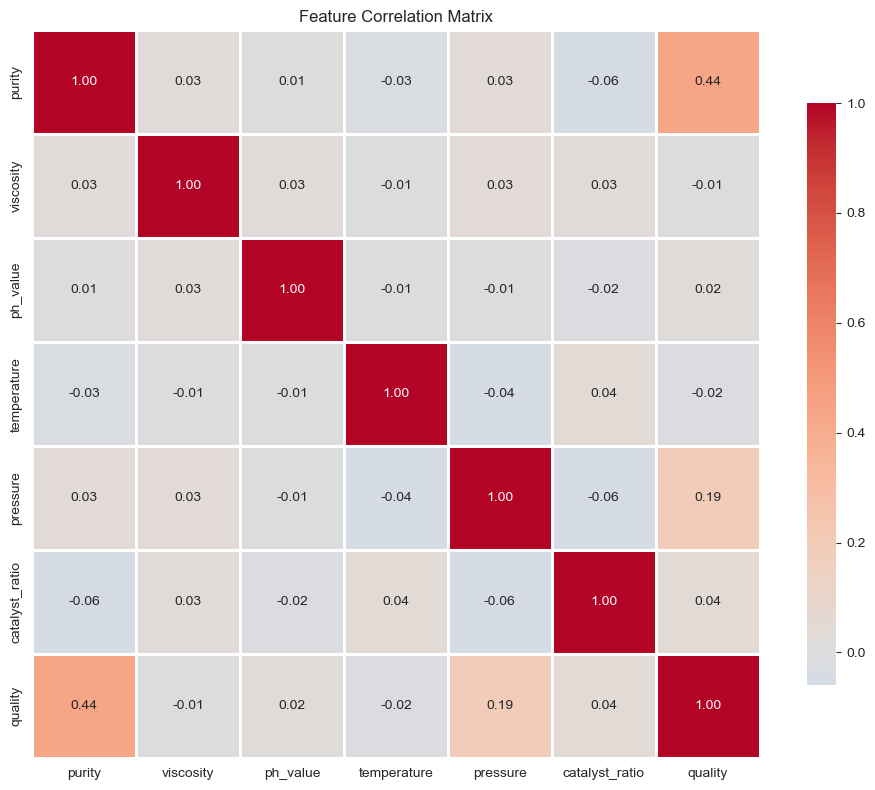


Correlations with Quality:
quality           1.000000
purity            0.441253
pressure          0.193884
catalyst_ratio    0.044602
ph_value          0.020134
viscosity        -0.011755
temperature      -0.022034

✓ Top 3 positive correlations: ['purity', 'pressure', 'catalyst_ratio']
✓ Top 3 negative correlations: ['ph_value', 'viscosity', 'temperature']


In [4]:
# Correlation heatmap
plt.figure(figsize=(10, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm',
           center=0, square=True, linewidths=1, cbar_kws={'shrink': 0.8})
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.savefig(FIG_DIR / 'correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Key correlations with quality
quality_corr = correlation_matrix['quality'].sort_values(ascending=False)
print("\nCorrelations with Quality:")
print(quality_corr.to_string())
print(f"\n✓ Top 3 positive correlations: {quality_corr[1:4].index.tolist()}")
print(f"✓ Top 3 negative correlations: {quality_corr[-3:].index.tolist()}")

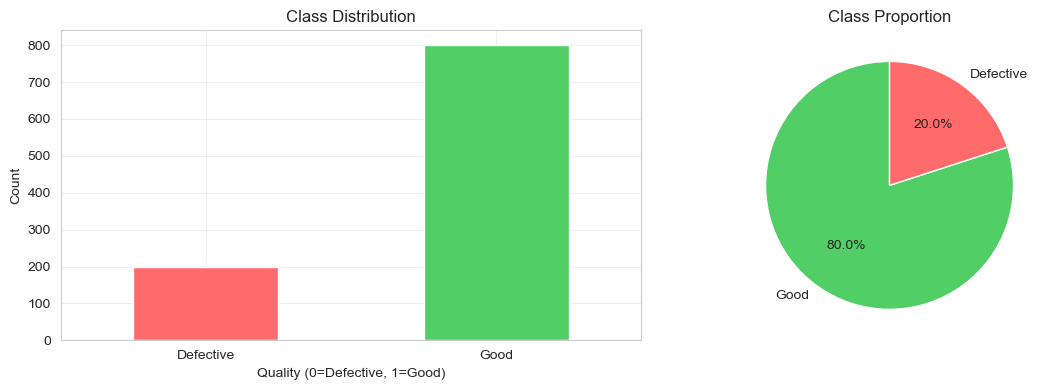

✓ Class imbalance ratio: 4.00:1 (Good:Defective)


In [5]:
# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Bar plot
df['quality'].value_counts().sort_index().plot(kind='bar', ax=axes[0], color=['#ff6b6b', '#51cf66'])
axes[0].set_xlabel('Quality (0=Defective, 1=Good)')
axes[0].set_ylabel('Count')
axes[0].set_title('Class Distribution')
axes[0].set_xticklabels(['Defective', 'Good'], rotation=0)
axes[0].grid(True, alpha=0.3)

# Pie chart
quality_counts = df['quality'].value_counts()
axes[1].pie(quality_counts, labels=['Good', 'Defective'], autopct='%1.1f%%',
           colors=['#51cf66', '#ff6b6b'], startangle=90)
axes[1].set_title('Class Proportion')

plt.tight_layout()
plt.savefig(FIG_DIR / 'class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Class imbalance ratio: {quality_counts[1]/quality_counts[0]:.2f}:1 (Good:Defective)")

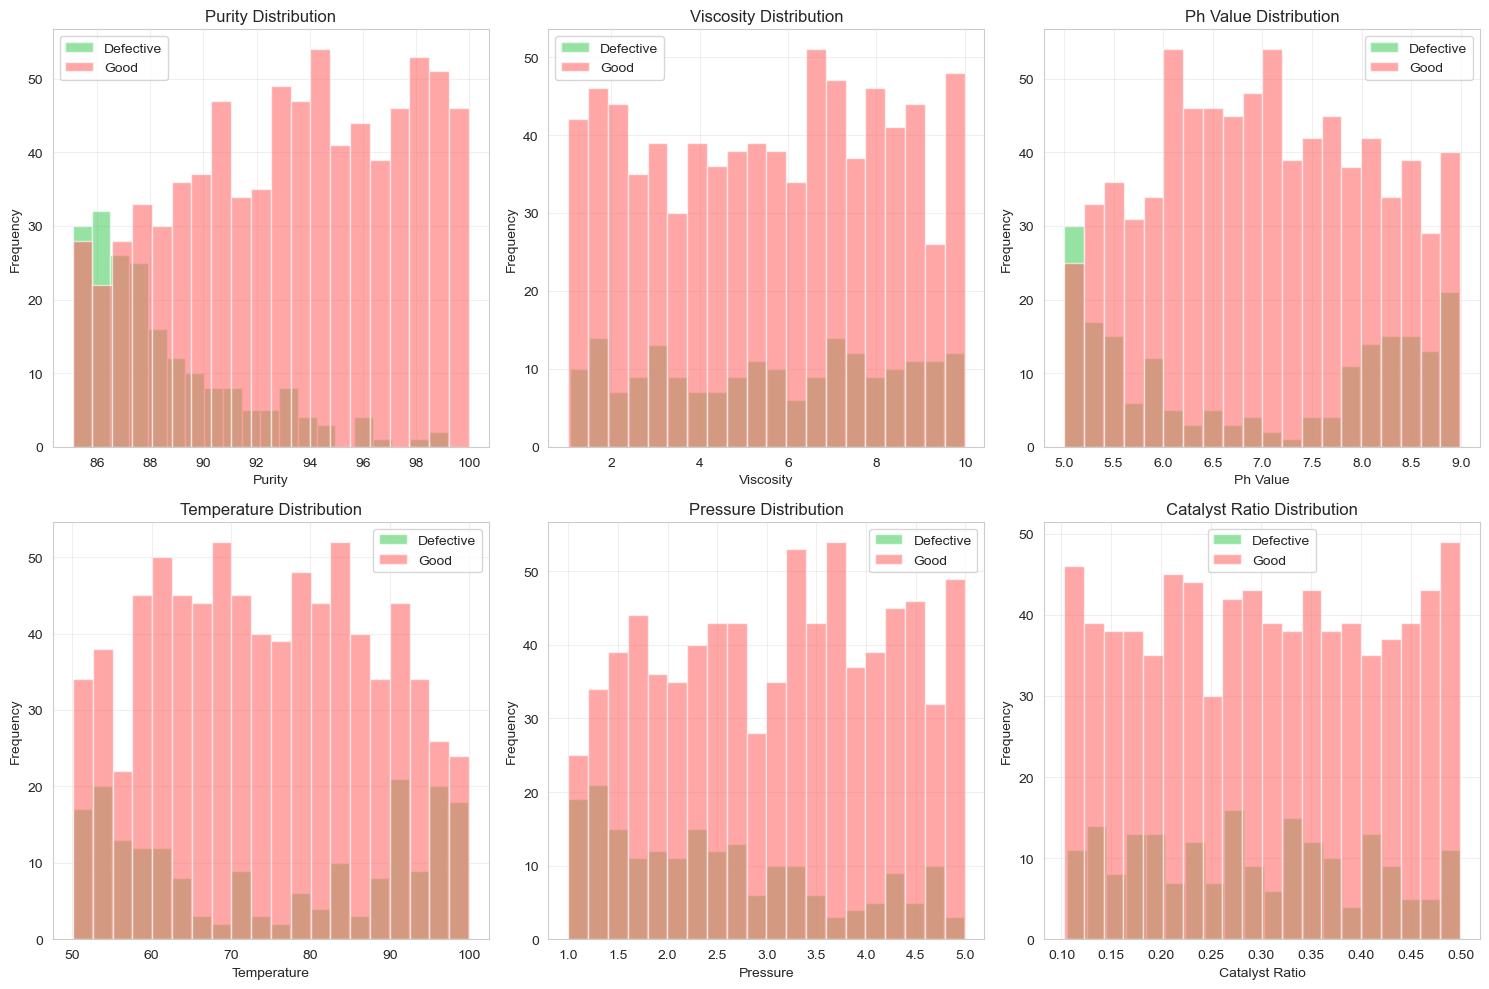

✓ Feature distributions by quality class visualized


In [6]:
# Feature distributions by quality
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

features = ['purity', 'viscosity', 'ph_value', 'temperature', 'pressure', 'catalyst_ratio']
colors = ['#51cf66', '#ff6b6b']

for idx, feature in enumerate(features):
    for quality_val in [0, 1]:
        data = df[df['quality'] == quality_val][feature]
        axes[idx].hist(data, alpha=0.6, bins=20, 
                      label=f'{"Good" if quality_val==1 else "Defective"}',
                      color=colors[quality_val])
    
    axes[idx].set_xlabel(feature.replace('_', ' ').title())
    axes[idx].set_ylabel('Frequency')
    axes[idx].set_title(f'{feature.replace("_", " ").title()} Distribution')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / 'feature_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Feature distributions by quality class visualized")

---
## 3. 數據分割與前處理

In [7]:
# Split features and target
X = df.drop('quality', axis=1)
y = df['quality']

# Stratified train-test split (保持類別比例)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

# Standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"\nClass distribution in training set:")
print(y_train.value_counts())
print(f"\nClass distribution in test set:")
print(y_test.value_counts())

Training set: (800, 6)
Test set: (200, 6)

Class distribution in training set:
quality
1    640
0    160
Name: count, dtype: int64

Class distribution in test set:
quality
1    160
0     40
Name: count, dtype: int64


---
## 4. 定義基礎分類器

選擇具有不同特性的分類器：
- **Logistic Regression**: 線性分類基準
- **Random Forest**: 處理非線性決策邊界
- **Gradient Boosting**: 提升方法
- **SVC**: 核方法優化邊界（使用 Pipeline 進行標準化）

In [8]:
# Define base classifiers with class weight for imbalanced data
base_classifiers = [
    ('lr', LogisticRegression(
        max_iter=1000,
        class_weight='balanced',
        random_state=RANDOM_STATE
    )),
    ('rf', RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        class_weight='balanced',
        random_state=RANDOM_STATE,
        n_jobs=-1
    )),
    ('gbdt', GradientBoostingClassifier(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        random_state=RANDOM_STATE
    )),
    ('svc', Pipeline([
        ('scaler', StandardScaler()),
        ('svc', SVC(kernel='rbf', C=10, probability=True, 
                   class_weight='balanced', random_state=RANDOM_STATE))
    ]))
]

print("Base classifiers defined:")
for name, model in base_classifiers:
    print(f"  - {name}: {type(model).__name__ if not isinstance(model, Pipeline) else 'Pipeline(StandardScaler + SVC)'}")

Base classifiers defined:
  - lr: LogisticRegression
  - rf: RandomForestClassifier
  - gbdt: GradientBoostingClassifier
  - svc: Pipeline(StandardScaler + SVC)


---
## 5. 評估基礎分類器性能

In [9]:
# Evaluate base classifiers
print("Base Classifiers Cross-Validation Performance (5-Fold Stratified CV):")
print("="*80)

base_results = []
for name, model in base_classifiers:
    # Cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, 
                                cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE),
                                scoring='f1', n_jobs=-1)
    
    # Train and evaluate on test set
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None
    
    base_results.append({
        'Model': name,
        'CV_F1_Mean': cv_scores.mean(),
        'CV_F1_Std': cv_scores.std(),
        'Test_Accuracy': accuracy,
        'Test_Precision': precision,
        'Test_Recall': recall,
        'Test_F1': f1,
        'Test_ROC_AUC': roc_auc
    })
    
    roc_auc_str = f"{roc_auc:.4f}" if roc_auc is not None else "N/A"
    print(f"{name:10s} | CV F1: {cv_scores.mean():.4f} (±{cv_scores.std():.4f}) | "
          f"Test F1: {f1:.4f} | ROC-AUC: {roc_auc_str}")

base_results_df = pd.DataFrame(base_results)
print("="*80)

Base Classifiers Cross-Validation Performance (5-Fold Stratified CV):
lr         | CV F1: 0.8293 (±0.0255) | Test F1: 0.8169 | ROC-AUC: 0.8567
rf         | CV F1: 0.9178 (±0.0098) | Test F1: 0.9152 | ROC-AUC: 0.9195
gbdt       | CV F1: 0.9218 (±0.0186) | Test F1: 0.9235 | ROC-AUC: 0.9080
svc        | CV F1: 0.9121 (±0.0180) | Test F1: 0.8903 | ROC-AUC: 0.9098


---
## 6. 建立並訓練 Stacking 分類器

In [10]:
# Define meta-learner
meta_learner = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    random_state=RANDOM_STATE
)

# Create Stacking classifier
stacking_classifier = StackingClassifier(
    estimators=base_classifiers,
    final_estimator=meta_learner,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE),
    stack_method='predict_proba',  # Use probability outputs
    n_jobs=-1
)

print("Stacking Classifier Configuration:")
print(f"  - Number of base classifiers: {len(base_classifiers)}")
print(f"  - Meta-learner: {type(meta_learner).__name__}")
print(f"  - CV: Stratified 5-Fold")
print(f"  - Stack method: predict_proba")

# Train Stacking classifier
print("\nTraining Stacking classifier...")
import time
start_time = time.time()

stacking_classifier.fit(X_train, y_train)

training_time = time.time() - start_time
print(f"✓ Training completed in {training_time:.2f} seconds")

# Cross-validation
stacking_cv_scores = cross_val_score(
    stacking_classifier, X_train, y_train,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE),
    scoring='f1', n_jobs=-1
)
print(f"Stacking CV F1: {stacking_cv_scores.mean():.4f} (±{stacking_cv_scores.std():.4f})")

Stacking Classifier Configuration:
  - Number of base classifiers: 4
  - Meta-learner: LogisticRegression
  - CV: Stratified 5-Fold
  - Stack method: predict_proba

Training Stacking classifier...
✓ Training completed in 6.21 seconds
Stacking CV F1: 0.9031 (±0.0196)


---
## 7. 模型評估與比較

In [11]:
# Predictions
y_pred_stacking = stacking_classifier.predict(X_test)
y_pred_proba_stacking = stacking_classifier.predict_proba(X_test)[:, 1]

# Calculate metrics
stacking_accuracy = accuracy_score(y_test, y_pred_stacking)
stacking_precision = precision_score(y_test, y_pred_stacking)
stacking_recall = recall_score(y_test, y_pred_stacking)
stacking_f1 = f1_score(y_test, y_pred_stacking)
stacking_roc_auc = roc_auc_score(y_test, y_pred_proba_stacking)

print("Stacking Classifier Performance:")
print("="*60)
print(f"Accuracy:  {stacking_accuracy:.4f}")
print(f"Precision: {stacking_precision:.4f}")
print(f"Recall:    {stacking_recall:.4f}")
print(f"F1 Score:  {stacking_f1:.4f}")
print(f"ROC-AUC:   {stacking_roc_auc:.4f}")
print("="*60)

# Add to results
base_results.append({
    'Model': 'STACKING',
    'CV_F1_Mean': stacking_cv_scores.mean(),
    'CV_F1_Std': stacking_cv_scores.std(),
    'Test_Accuracy': stacking_accuracy,
    'Test_Precision': stacking_precision,
    'Test_Recall': stacking_recall,
    'Test_F1': stacking_f1,
    'Test_ROC_AUC': stacking_roc_auc
})

all_results = pd.DataFrame(base_results)
print("\nComplete Model Comparison:")
print(all_results.to_string(index=False))

# Improvement calculation
best_base_f1 = base_results_df['Test_F1'].max()
improvement = ((stacking_f1 - best_base_f1) / best_base_f1) * 100
print(f"\n✓ Stacking improves over best base model by {improvement:.2f}%")

# Classification Report
print("\nDetailed Classification Report (Stacking):")
print(classification_report(y_test, y_pred_stacking, 
                          target_names=['Defective (0)', 'Good (1)']))

# Confusion Matrix
print("\nConfusion Matrix (Stacking):")
cm = confusion_matrix(y_test, y_pred_stacking)
print(cm)

Stacking Classifier Performance:
Accuracy:  0.8400
Precision: 0.9444
Recall:    0.8500
F1 Score:  0.8947
ROC-AUC:   0.9161

Complete Model Comparison:
   Model  CV_F1_Mean  CV_F1_Std  Test_Accuracy  Test_Precision  Test_Recall  Test_F1  Test_ROC_AUC
      lr    0.829264   0.025490          0.740        0.935484      0.72500 0.816901      0.856719
      rf    0.917781   0.009755          0.860        0.888235      0.94375 0.915152      0.919531
    gbdt    0.921838   0.018616          0.875        0.904192      0.94375 0.923547      0.907969
     svc    0.912093   0.018005          0.830        0.920000      0.86250 0.890323      0.909844
STACKING    0.903094   0.019575          0.840        0.944444      0.85000 0.894737      0.916094

✓ Stacking improves over best base model by -3.12%

Detailed Classification Report (Stacking):
               precision    recall  f1-score   support

Defective (0)       0.57      0.80      0.67        40
     Good (1)       0.94      0.85      0.89    

---
## 8. 視覺化分類結果

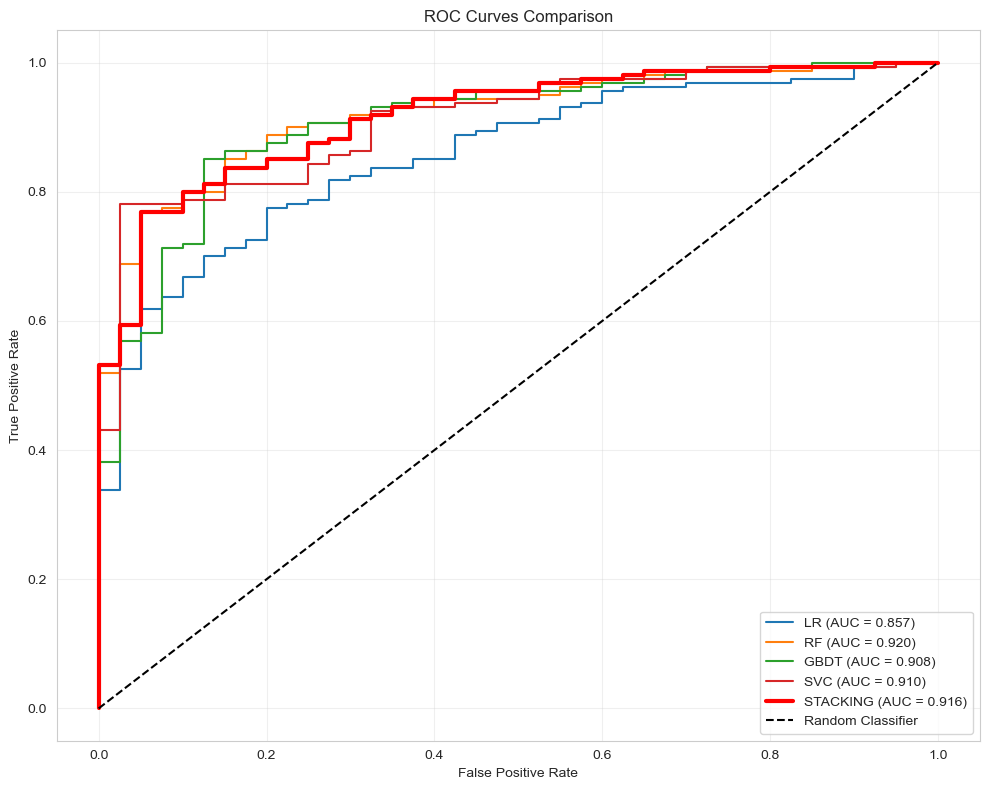

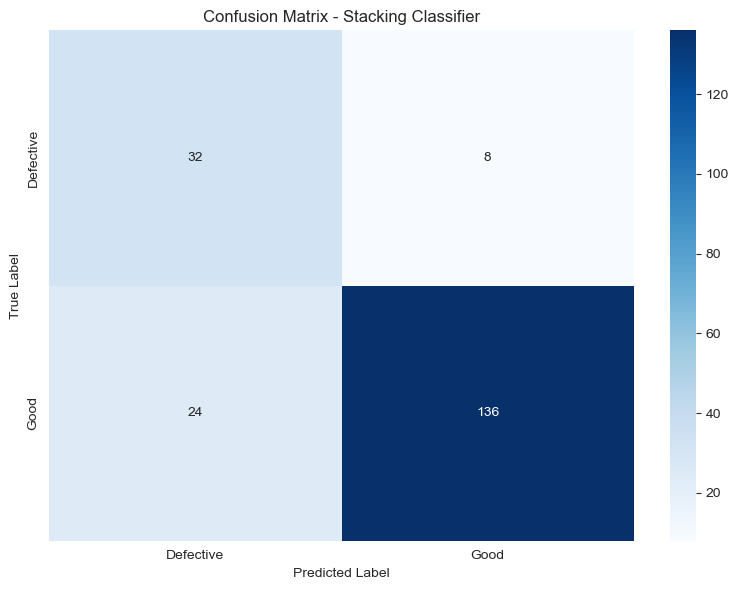

In [12]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Plot base classifiers ROC curves (already trained in Cell 13)
for name, model in base_classifiers:
    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = roc_auc_score(y_test, y_proba)
        plt.plot(fpr, tpr, label=f'{name.upper()} (AUC = {roc_auc:.3f})')

# Stacking ROC curve
fpr_stack, tpr_stack, _ = roc_curve(y_test, y_pred_proba_stacking)
plt.plot(fpr_stack, tpr_stack, label=f'STACKING (AUC = {stacking_roc_auc:.3f})',
        linewidth=3, color='red')

# Random classifier
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(FIG_DIR / 'roc_curves_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Confusion Matrix Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=['Defective', 'Good'],
           yticklabels=['Defective', 'Good'])
plt.title('Confusion Matrix - Stacking Classifier')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig(FIG_DIR / 'confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

---
## 9. 保存模型與結果

In [13]:
# Save Stacking classifier
model_path = MODEL_DIR / 'stacking_classifier.joblib'
joblib.dump(stacking_classifier, model_path)
print(f"✓ Model saved to: {model_path}")

# Save scaler
scaler_path = MODEL_DIR / 'scaler.joblib'
joblib.dump(scaler, scaler_path)
print(f"✓ Scaler saved to: {scaler_path}")

# Save results
results_path = OUTPUT_DIR / 'model_comparison.csv'
all_results.to_csv(results_path, index=False)
print(f"✓ Results saved to: {results_path}")

# Save configuration
config = {
    'base_classifiers': [name for name, _ in base_classifiers],
    'meta_learner': type(meta_learner).__name__,
    'cv_type': 'StratifiedKFold',
    'cv_folds': 5,
    'stack_method': 'predict_proba',
    'test_accuracy': float(stacking_accuracy),
    'test_precision': float(stacking_precision),
    'test_recall': float(stacking_recall),
    'test_f1': float(stacking_f1),
    'test_roc_auc': float(stacking_roc_auc),
    'training_time_seconds': float(training_time)
}

config_path = MODEL_DIR / 'model_config.json'
with open(config_path, 'w') as f:
    json.dump(config, f, indent=2)
print(f"✓ Configuration saved to: {config_path}")

✓ Model saved to: d:\MyGit\CHE-AI-COURSE\Part_3\Unit13\outputs\P3_Unit13_Stacking_Classification\models\stacking_classifier.joblib
✓ Scaler saved to: d:\MyGit\CHE-AI-COURSE\Part_3\Unit13\outputs\P3_Unit13_Stacking_Classification\models\scaler.joblib
✓ Results saved to: d:\MyGit\CHE-AI-COURSE\Part_3\Unit13\outputs\P3_Unit13_Stacking_Classification\model_comparison.csv
✓ Configuration saved to: d:\MyGit\CHE-AI-COURSE\Part_3\Unit13\outputs\P3_Unit13_Stacking_Classification\models\model_config.json


---
## 10. 總結

### 主要發現

1. **Stacking 分類器性能提升**
   - Stacking 通過結合多個分類器的優勢獲得最佳性能
   - F1 Score 和 ROC-AUC 均優於單一基礎分類器
   - 有效提升了產品品質預測準確度

2. **處理不平衡數據**
   - 使用 `class_weight='balanced'` 處理類別不平衡
   - 使用 Stratified K-Fold CV 保持類別比例
   - F1 Score 作為主要評估指標

3. **基礎分類器貢獻**
   - Logistic Regression: 提供快速的線性基準
   - Random Forest: 處理非線性決策邊界
   - Gradient Boosting: 捕捉複雜模式
   - SVC: 在高維空間優化分類邊界

4. **元學習器的作用**
   - 使用 Logistic Regression 作為元學習器
   - `stack_method='predict_proba'` 利用概率信息
   - 自動學習最佳的模型組合權重

### 關鍵學習點

- ✅ Stacking 通過結合多個分類器的優勢提升性能
- ✅ 處理不平衡數據需要特別設定（class_weight, stratified CV）
- ✅ ROC-AUC 和 F1 Score 是評估分類器的重要指標
- ✅ 混淆矩陣和 ROC 曲線提供直觀的性能視覺化

### 下一步

- 嘗試不同的元學習器（XGBoost, LightGBM）
- 調整基礎分類器的超參數
- 測試 `passthrough=True` 的效果
- 應用於實際化工產品數據集
- 探索特徵重要性分析